# Video Face Manipulation Detection Through Ensemble of CNNs
Image and Sound Processing Lab - Politecnico di Milano
- Nicolò Bonettini
- Edoardo Daniele Cannas
- Sara Mandelli
- Luca Bondi
- Paolo Bestagini


In [1]:
!git clone https://github.com/polimi-ispl/icpr2020dfdc
!pip install efficientnet-pytorch
!pip install -U git+https://github.com/albu/albumentations > /dev/null
%cd icpr2020dfdc

Cloning into 'icpr2020dfdc'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 645 (delta 96), reused 80 (delta 80), pack-reused 537
Receiving objects: 100% (645/645), 99.63 MiB | 37.76 MiB/s, done.
Resolving deltas: 100% (336/336), done.
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=00ab8cdbb34d101b90913e252705f08be6681318f9e1d1c69198a4e13bcae05a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-q1qozbj5
/content/icpr2020dfdc


In [2]:
import torch
from torch.utils.model_zoo import load_url
from torchvision.transforms import ToPILImage
from PIL import Image, ImageChops
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace
from architectures import fornet,weights
from isplutils import utils

## Parameters

In [3]:
"""
Choose an architecture between
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
- Xception
"""
net_model = 'EfficientNetAutoAttB4'

"""
Choose a training dataset between
- DFDC
- FFPP
"""
train_db = 'DFDC'

In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224

## Initialization

In [5]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:01<00:00, 73.3MB/s]


Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetAutoAttB4_DFDC_bestval-72ed969b2a395fffe11a0d5bf0a635e7260ba2588c28683630d97ff7153389fc.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetAutoAttB4_DFDC_bestval-72ed969b2a395fffe11a0d5bf0a635e7260ba2588c28683630d97ff7153389fc.pth
100%|██████████| 33.9M/33.9M [00:00<00:00, 45.6MB/s]


<All keys matched successfully>

In [13]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [6]:
facedet = BlazeFace().to(device)
facedet.load_weights("blazeface/blazeface.pth")
facedet.load_anchors("blazeface/anchors.npy")
face_extractor = FaceExtractor(facedet=facedet)

## Load images

In [20]:
im_real = Image.open('notebook/samples/lynaeydofd_fr0.jpg')
im_fake = Image.open('notebook/samples/ajpzditips_mp4_fr000_subj0.jpg')

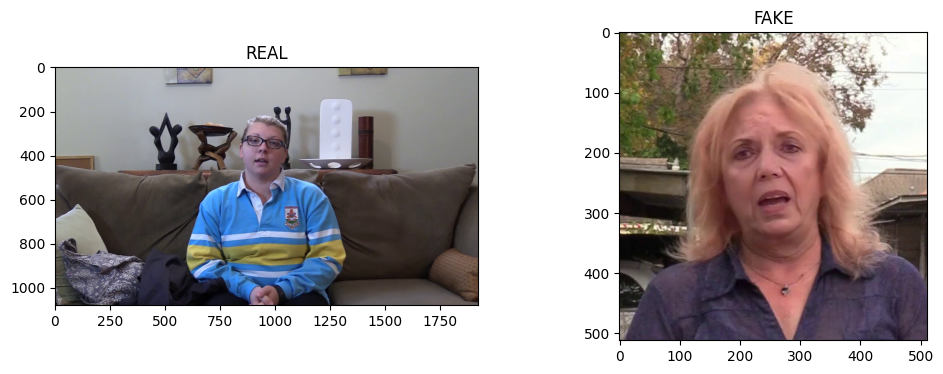

In [21]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].imshow(im_real)
ax[0].set_title('REAL')

ax[1].imshow(im_fake)
ax[1].set_title('FAKE');

## Extract faces

In [22]:
im_real_faces = face_extractor.process_image(img=im_real)
im_fake_faces = face_extractor.process_image(img=im_fake)

In [23]:
im_real_face = im_real_faces['faces'][0] # take the face with the highest confidence score found by BlazeFace
im_fake_face = im_fake_faces['faces'][0] # take the face with the highest confidence score found by BlazeFace

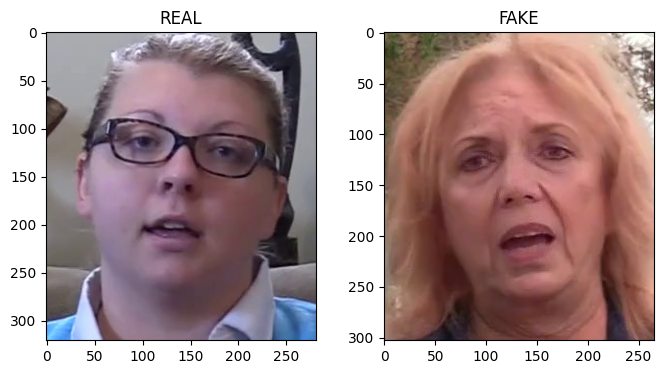

In [24]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face)
ax[1].set_title('FAKE');

## Predict scores

In [25]:
faces_t = torch.stack( [ transf(image=im)['image'] for im in [im_real_face,im_fake_face] ] )

with torch.no_grad():
    faces_pred = torch.sigmoid(net(faces_t.to(device))).cpu().numpy().flatten()

In [26]:
"""
Print scores.
A score close to 0 predicts REAL. A score close to 1 predicts FAKE.
"""
print('Score for REAL face: {:.4f}'.format(faces_pred[0]))
print('Score for FAKE face: {:.4f}'.format(faces_pred[1]))

Score for REAL face: 0.0115
Score for FAKE face: 0.6995


## Get attention

In [27]:
faces_t = torch.stack( [ transf(image=im)['image'] for im in [im_real_face,im_fake_face] ] )

with torch.no_grad():
    if hasattr(net,'feat_ext'):
        atts = net.feat_ext.get_attention(faces_t.to(device)).cpu()
    else:
        atts = net.get_attention(faces_t.to(device)).cpu()

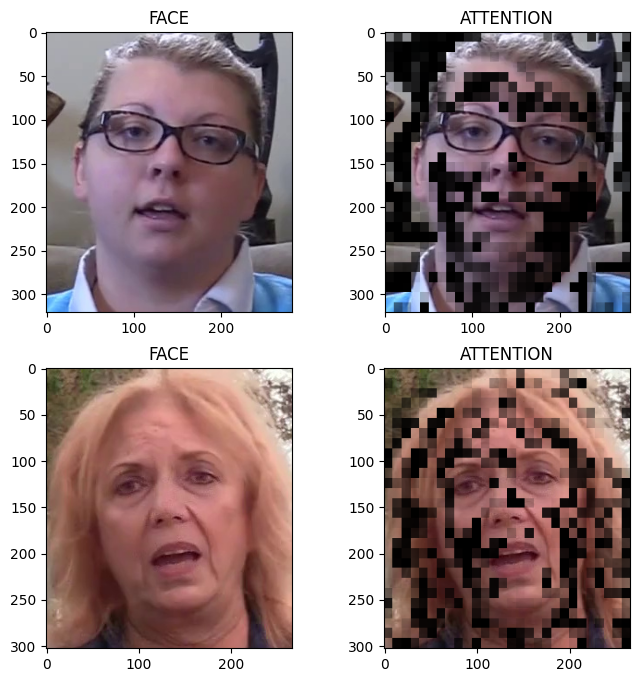

In [28]:
fig,ax = plt.subplots(2,2,figsize=(8,8))

for idx, (face_t, att) in enumerate(zip([im_real_face,im_fake_face], atts)):
    face_im = ToPILImage()(face_t)
    att_img = ToPILImage()(att)
    att_img = att_img.resize(face_im.size, resample=Image.NEAREST).convert('RGB')
    face_att_img = ImageChops.multiply(face_im, att_img)

    ax[idx, 0].imshow(face_im)
    ax[idx, 0].set_title('FACE')
    ax[idx, 1].imshow(face_att_img)
    ax[idx, 1].set_title('ATTENTION')